In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

DATASET_DIR = 'fungal_classification'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5  
EPOCHS = 15


In [3]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'valid'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 5000 images belonging to 5 classes.
Found 899 images belonging to 5 classes.
Found 902 images belonging to 5 classes.


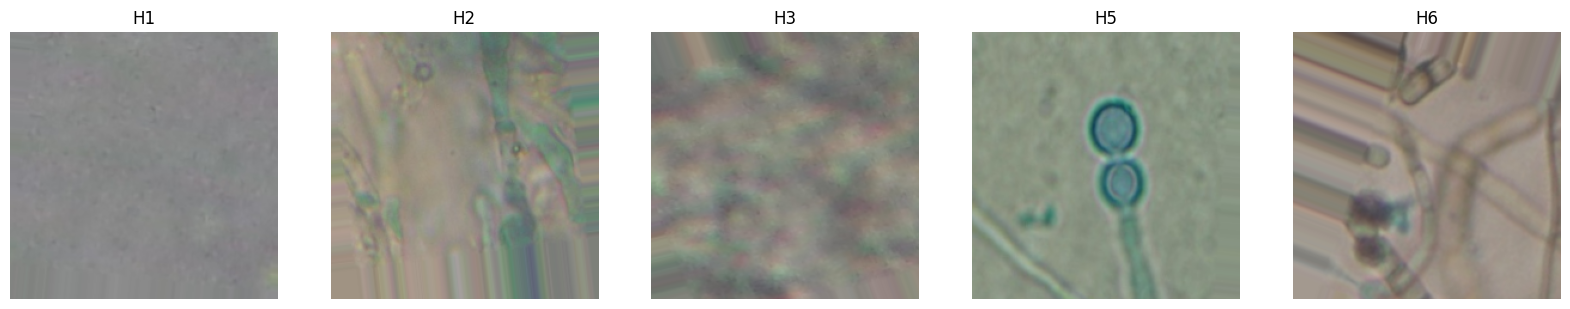

In [4]:
def show_sample_images(generator):
    class_labels = list(generator.class_indices.keys())
    fig, axes = plt.subplots(1, len(class_labels), figsize=(20, 5))
    for i, class_label in enumerate(class_labels):
        for images, labels in generator:
            idx = np.argmax(labels, axis=1)
            for j, label_idx in enumerate(idx):
                if label_idx == i:
                    axes[i].imshow(images[j])
                    axes[i].set_title(class_label)
                    axes[i].axis('off')
                    break
            break
    plt.show()

show_sample_images(train_generator)


In [5]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             

 Total params: 32,872,517 (125.40 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [6]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator
)


c:\Users\gfxsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 737s 5s/step - accuracy: 0.3246 - loss: 2.6385 - val_accuracy: 0.5484 - val_loss: 1.2953
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.3813 - loss: 1.3966 - val_accuracy: 0.5228 - val_loss: 1.2345
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 748s 5s/step - accuracy: 0.4177 - loss: 1.3316 - val_accuracy: 0.5072 - val_loss: 1.2797
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.4302 - loss: 1.3046 - val_accuracy: 0.4505 - val_loss: 1.3183
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 764s 5s/step - accuracy: 0.4138 - loss: 1.3233 - val_accuracy: 0.5017 - val_loss: 1.2196
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - accuracy: 0.4336 - loss: 1.2995 - val_accuracy: 0.4260 - val_loss: 1.2360
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 750s 5s/step - accuracy: 0.4254 - loss: 1.3000 - val_accuracy: 0.5773 - val_loss: 1.2018
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 750s 5s/step - accuracy: 0.4363 - loss: 1.2754 - val_accu

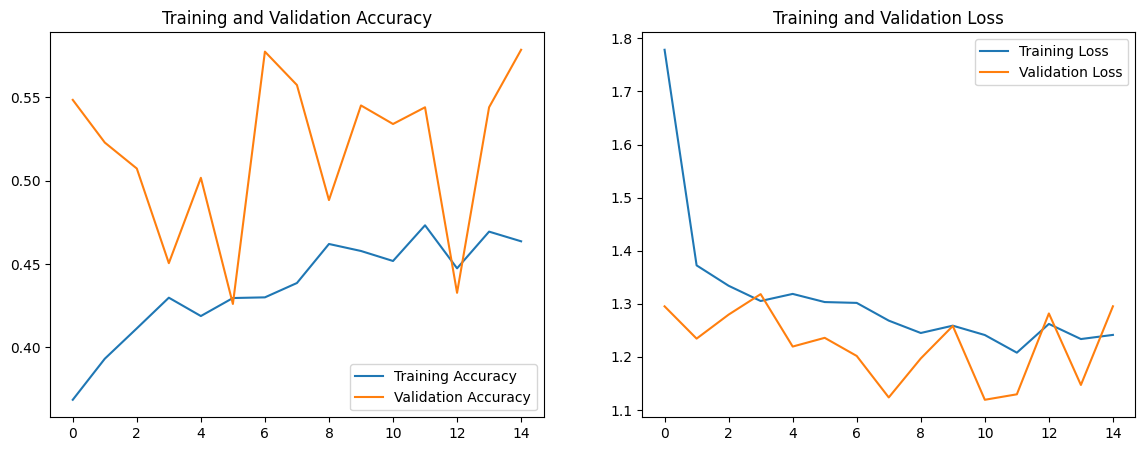

In [7]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)


29/29 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step
Classification Report:
              precision    recall  f1-score   support

          H1       0.64      0.79      0.71       437
          H2       0.22      0.05      0.08       233
          H3       0.31      0.50      0.38        82
          H5       0.84      0.61      0.71        80
          H6       0.45      0.77      0.57        70

    accuracy                           0.56       902
   macro avg       0.49      0.54      0.49       902
weighted avg       0.50      0.56      0.50       902



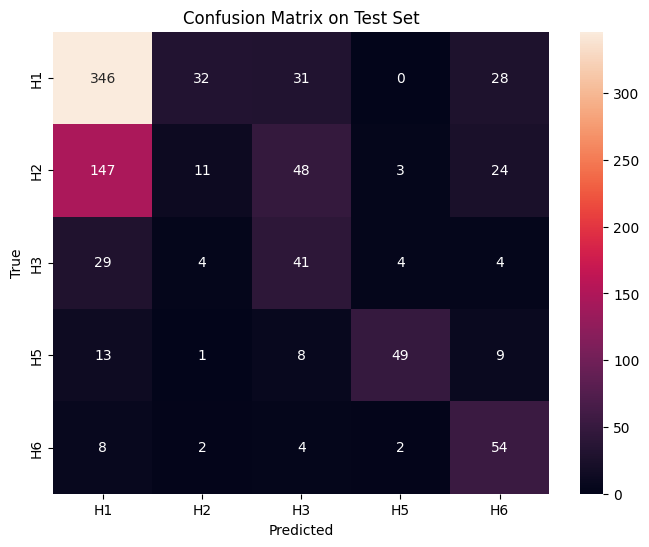

In [8]:
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()


C:\Users\gfxsc\AppData\Local\Temp\ipykernel_39744\1240365784.py:39: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


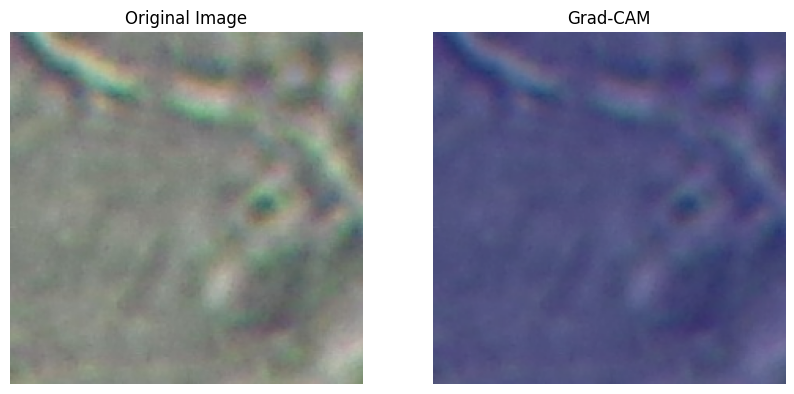

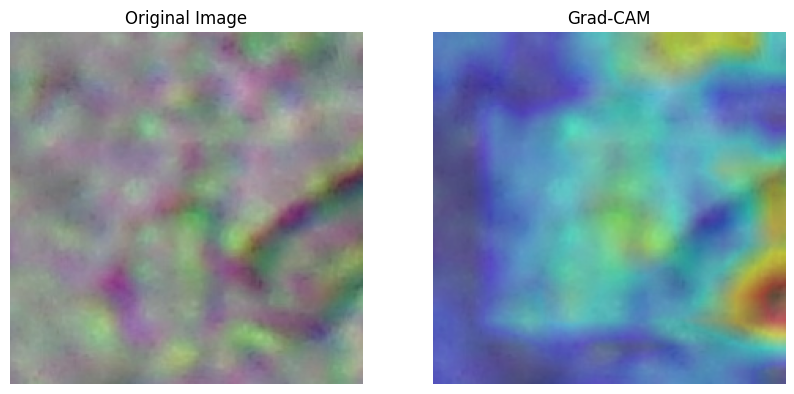

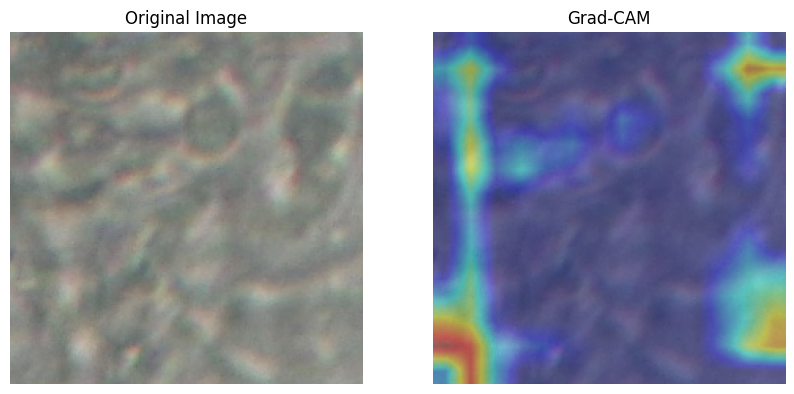

In [10]:
import cv2
import random

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):

    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)  

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.show()

test_filenames = test_generator.filenames
for _ in range(3):
    img_path = os.path.join(DATASET_DIR, 'test', test_filenames[random.randint(0, len(test_filenames)-1)])
    img_array = get_img_array(img_path, size=IMG_SIZE)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='block5_conv4')
    save_and_display_gradcam(img_path, heatmap)
